# 04-04 - Stochastic Block Model and Networks with Heterogeneous Degree Distributions

*May 17 2023*

In the previous notebook, we have seen that the standard stochastic block model discussed so far fails to detect communities in an empirical network. This failure is due to the heterogeneous degree distribution of the network, which leads to a detection of communities that correspond to groups of high- and low-degree nodes. To address this issue, we implement the degree-corrected stochastic block model and use it to infer communities.

In [2]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('default')
sns.set_style("whitegrid")

    
from numpy import linalg as npl
import scipy as sp

import scipy.special
from decimal import *
import string
from collections import Counter, defaultdict

In [3]:
def log(x):
    if x == 0:
        return 0.0
    else:
        return np.log(x)

We read the Karate club network and assign ground truth communities as before.

In [5]:
n = pp.io.graphtool.read_netzschleuder_network('karate', '77')

reverse_index = {v:k for k, v in n.nodes.index.items()}
ground_truth = [n.nodes[reverse_index[i]]['groups']-1 for i in range(n.number_of_nodes())]
print(ground_truth)

colors = sns.color_palette("Set1", 10)
for v in n.nodes:
    v['color'] = colors[v['groups']-1]
n.plot(edge_color='gray')

[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]


We now implement a likelihood function of the degree-corrected block model. Compared to the previous version without degree correction, we count the sum of node degrees within all communities and use this in our maximum likelihood estimate.

In [6]:
def SBM_dc_likelihood(z, n: pp.Network):

    m = n.number_of_edges()
    B = len(set(z))

    L = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))
    for k in range(B):
        for l in range(B):
            # count number of links
            for e in n.edges:
                if (z[n.nodes.index[e.v.uid]] == k and z[n.nodes.index[e.w.uid]] == l) or (z[n.nodes.index[e.v.uid]] == l and z[n.nodes.index[e.w.uid]] == k):
                    E[k,l] += 1
            if k == l:
                E[k,l] = 2*E[k,l]

    # kappa[k] counts sum of degrees within block k
    kappa = defaultdict(lambda: 0)
    
    for k in range(B):
        for v in n.nodes:
            if (z[n.nodes.index[v.uid]] == k):
                kappa[k] += n.degrees()[v.uid]

    for r in range(B):
        for s in range(k+1):
            L+= E[r,s] * log(E[r,s]/(kappa[r]*kappa[s]))

    return L

The simulated annealing algorithm is the same as before:

In [7]:
def simulated_annealing(network: pp.Network, B, cooling_slowness = 100, changes_per_iter=1, iterations=1000):
    likelihoods = []
    n = network.number_of_nodes()
    z = np.zeros(n, dtype=int)
    for i in range(n):
        z[i] = int(np.random.randint(B))
    l = SBM_dc_likelihood(z, network)

    # we want to output the cooling temperatures to see the cooling schedule
    temperatures = []

    for i in tqdm(range(iterations)):

        t = (1+cooling_slowness)/(i+1+cooling_slowness)

        # randomly change community of random node
        z_new = z.copy()
        z_new[np.random.randint(n)] = int(np.random.randint(B))

        for i in range(changes_per_iter):
            i = np.random.choice(network.number_of_nodes())
            z_new[i] = np.random.choice(B)
        l_new = SBM_dc_likelihood(z_new, network)
        if l_new >= l or np.random.random() <= np.exp(-(l-l_new)/t):
            z = z_new
            l = l_new

        likelihoods.append(np.exp(l))
        temperatures.append(t)
    return z, likelihoods, temperatures

Unfortunately, the inclusion of node degrees in the likelihood calculation makes the likelihood *landscape* more complicated, which means that it is more difficult to tune the simple simulated annealing algorithm such that it does not get stuck in suboptimal solutions depending on the initial community assignment. A simple way to deal with this is to run the optimization multiple times for different initial conditions and then take the solution with maximum likelihood. This could even be parallelized, since the different optimization runs can be executed independently.

In [8]:
max_l = [-np.inf]
max_z = None 
max_t = None
for i in range(10):
    z,l,t = simulated_annealing(n, B=2, cooling_slowness=200, changes_per_iter=1, iterations=500)
    if l[-1] > max_l[-1]:
        max_l = l
        max_z = z 
        max_t = t

print(max_l[-1])
colors = sns.color_palette("Set1", 10)
for v in n.nodes:
    v['color'] = colors[max_z[n.nodes.index[v.uid]]]
n.plot(edge_color='gray')

/tmp/ipykernel_19338/4122636442.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

4.467677e-317


We find that we can use this approach to reliable find a reasonable community structure for the Karate club network. In reality, we would use more sophisticated heuristic optimization algorithms that are specifically tuned to the degree-corrected stochastic block model (see, e.g., [T Peixoto 2014](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.89.012804)).

In [9]:
max_l_gt = SBM_dc_likelihood(ground_truth, n)
print(np.exp(max_l_gt))

9.46403e-319


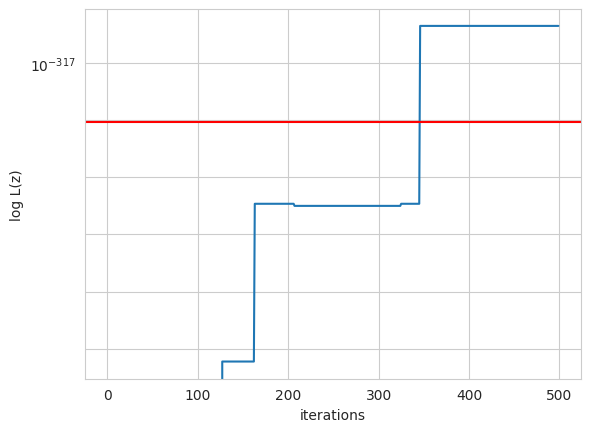

In [10]:
plt.plot(range(500), max_l)
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('log L(z)')
plt.axhline(y=np.exp(max_l_gt), color='red')

We finally reuse the code to calculate the normalized mutual information (NMI), which allows us to evaluate the quality of detected communities.

In [11]:
def log2(x):
    if x != 0:
        return np.log2(x)
    else:
        return 0

def P(z):
    c = Counter(z)
    total = sum(c.values(), 0.0)
    for key in c:
        c[key] /= total
    return c

def JointProb(z1, z2):
    p = Counter()
    for i in range(len(z1)):
        p[(int(z1[i]), int(z2[i]))] += 1
    total = sum(p.values(), 0.0)
    for key in p:
        p[key] /= total
    return p

def H(p):   
    h = 0
    for i in p:
        h -= p[i] * log2(p[i])
    return h

def MI(z1, z2):
    max_val = max(max(z1), max(z2))
    
    # marginal prob. dist. 
    marginal1 = P(z1)
    marginal2 = P(z2)
    
    # joint prob. dist 
    joint = JointProb(z1, z2)

    mi = 0
    for x in range(max_val+1):
        for y in range(max_val+1):
            mi += joint[(x,y)] * log2(joint[(x,y)]/(marginal1[x]*marginal2[y]))
    return mi


def NMI(z1, z2):
    # compute entropies
    h1 = H(P(z1))
    h2 = H(P(z1))
    # compute MI
    mi = MI(z1, z2)
    return 2 * mi/(h1 + h2) 

In [12]:
NMI(max_z, ground_truth)

0.8382174761998225